## Getting the expression of voltage-gated potassium channel, Kv4.3, in human hippocampus across different age groups

In this section, we will interact with the Developing Human Transcriptome (https://www.brainspan.org/rnaseq/search/index.html)  to obtain potassium channel expression in hippocampus across subjects of different ages. The gene coding Kv4.3 is KCND3 (Carasquillo et al. 2012)

Firstly, we need to find the gene id for the gene KCND3. 

In [3]:
import requests
import json
import pandas as pd
import numpy as np

service = "http://api.brain-map.org/api/v2/data/query.json?criteria="

# getting gene ID using the RMA query function

gene_acronym = 'KCND3'
probe_type = 'NcbiGene'

result = requests.get("%smodel::Gene,\
rma::criteria,[acronym$eq'%s\'][type$eq'%s\'],organism[name$eq'Homo Sapiens'],\
rma::options[only$eq'genes.id']" % (service, gene_acronym, probe_type)).json()
gene_id = result['msg'][1]['id']
probe_id = result['msg'][0]['id']
print ('The gene ID for KCND3 in the database is: ', gene_id)

The gene ID for KCND3 in the database is:  3727


Next, I want to know about the donors who provided the hippocampal KCND3 expression data. What are their donor ids? How old were they?

In [31]:
#Fetching data for all donors with KCND expression data at hippocampus
donor_info = requests.get("http://api.brain-map.org/api/v2/data/query.json?criteria=service::dev_human_expression\
[set$eq'exon_microarray_genes'][probes$eq3727][structures$eq10294]").json()

#getting a list of donors, with their age donor id.
donor_info_samples = donor_info['msg']
donor_list = donor_info_samples['samples']
younger_adults_id = []
younger_adults_age = []
older_adults_id = []
older_adults_age = []
category = []
#print (donor_list)


## examine the age of each donor, and categorize them into 'young' or 'old' 
for indiv_donor in donor_list:      
    indiv_info = indiv_donor['donor']
    indiv_age = indiv_info['age']
    age_num = indiv_age.split(' ')[0]
    if not 'pcw' in indiv_age:
        if ('yrs' in indiv_age) and (int(age_num) > 20):
            older_adults_id.append(indiv_info['id'])
            older_adults_age.append(indiv_age)
            category.append('older')
        else:
            younger_adults_id.append(indiv_info['id'])
            younger_adults_age.append(indiv_age)
            category.append('younger')
all_donors = younger_adults_id + older_adults_id
all_age = younger_adults_age + older_adults_age
print ('These are the IDs of all donors:', all_donors)
print ('\n')
print ('The following are their ages: ', all_age)

These are the IDs of all donors: [12296, 12890, 12830, 12979, 12980, 12841, 12981, 12289, 12831, 12984, 12832, 13057, 12300, 12290, 12302, 12303, 12304]


The following are their ages:  ['4 mos', '4 mos', '1 yrs', '2 yrs', '3 yrs', '8 yrs', '8 yrs', '11 yrs', '13 yrs', '18 yrs', '19 yrs', '21 yrs', '23 yrs', '30 yrs', '36 yrs', '37 yrs', '40 yrs']


Now, I will get the actual expression values from each donor. Gene expression is measured by exon microarray probes. 

In [32]:
##Getting KCND3 expression from each donor
all_kvexp_hippo = []
for each_donor in all_donors:
    all_kvexp = requests.get("http://api.brain-map.org/api/v2/data/query.json?criteria=service::dev_human_expression\
[set$eq'exon_microarray_genes'][probes$eq3727][structures$eq10294][donors$eq'%s\']" % (each_donor)).json()
##cleaning data
    all_kvexp_msg = all_kvexp['msg']
    gene_related_info = pd.DataFrame(all_kvexp_msg['probes'])
    expression_lvl = gene_related_info['expression_level'].tolist()
    kv_expression = expression_lvl[0][0]
##getting expression value and combining with the donor ID and age together
    if type (kv_expression) == 'str':
        kv_expression = float (kv_expression)
    all_kvexp_hippo.append (kv_expression)
result_dict = {'Donor_id': all_donors, 'Donor_age': all_age, 'Category': category, 'KCND3_expression': all_kvexp_hippo}
result_df = pd.DataFrame (result_dict)
print (result_df)


    Donor_id Donor_age Category KCND3_expression
0      12296     4 mos  younger           8.7525
1      12890     4 mos  younger             None
2      12830     1 yrs  younger           8.8687
3      12979     2 yrs  younger           7.2277
4      12980     3 yrs  younger           7.1818
5      12841     8 yrs  younger           8.5025
6      12981     8 yrs  younger             None
7      12289    11 yrs  younger             None
8      12831    13 yrs  younger           8.4413
9      12984    18 yrs  younger           7.1473
10     12832    19 yrs  younger             None
11     13057    21 yrs    older           8.8564
12     12300    23 yrs    older           8.0415
13     12290    30 yrs    older           8.8200
14     12302    36 yrs    older           9.2727
15     12303    37 yrs    older           9.0706
16     12304    40 yrs    older           7.5593


To plot the expression against age groups, I need to clean the data (remove those who do not have expression values) and further categorize subjects by age. 

Text(0.5, 1.0, 'Figure 3. Distribution of KCND3 \n expression of young subjects')

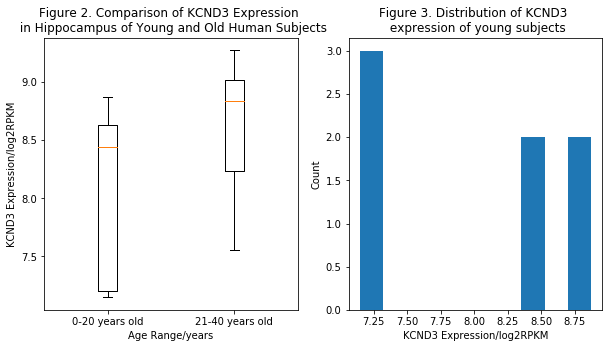

In [51]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(1,2,figsize = (10,5))

# Dropping subjects without KCND3 expression
result_cleaned = result_df.dropna()
result_cleaned.set_index('Donor_id')

#grouping the expression values to either 'young' or 'old' category
young = result_cleaned[result_cleaned['Category'] == 'younger']
old = result_cleaned[result_cleaned['Category'] == 'older']
young_expression = young['KCND3_expression'].values.tolist()
old_expression = old['KCND3_expression'].values.tolist()
data = [young_expression,old_expression]
young_expression = list(map(float, young_expression))
old_expression = list(map(float,old_expression))

data = [young_expression, old_expression]

# Create a boxplot of the expression values of young(0-20yrs) and old(21-40yrs) subjects
ax[0].boxplot(data)
ax[0].set_xlabel('Age Range/years')
ax[0].set_ylabel('KCND3 Expression/log2RPKM')   
ax[0].set_xticklabels(['0-20 years old','21-40 years old'])
ax[0].set_title('Figure 2. Comparison of KCND3 Expression \n in Hippocampus of Young and Old Human Subjects')
ax[1].hist(young_expression)
ax[1].set_xlabel('KCND3 Expression/log2RPKM') 
ax[1].set_ylabel('Count')
ax[1].set_title('Figure 3. Distribution of KCND3 \n expression of young subjects')

Figure 2 shows that younger subjects have a wider range of KCND3 expression in hippocampus than older subjects. Figure 3 showed that young subjects' expression values are not in a normal distribution. Younger subjects also seem to have lower hippocampal KCND3 expression compared to older subjects. In oder to figure out if such observation is statistically significant, we would like to conduct an Mann-Whitney U Test regarding the two groups' expression values. 

In [52]:
# t-test across two groups of data
from scipy import stats
ttest_statistic, ttest_pVal = stats.mannwhitneyu(young_expression,old_expression)
print ("The p-Value for the t-test is: ", ttest_pVal)
print ('Since the p value is higher than 0.05, we have insufficient evidence to claim that the hippocampal KCND expression of the young\
and old subjects are different.')

The p-Value for the t-test is:  0.06680720126885807
Since the p value is higher than 0.05, we have insufficient evidence to claim that the hippocampal KCND expression of the youngand old subjects are different.
